# Procesowanie obrazów siatkówki oka w celu wykrycia charakterysrycznych cech 

Do przeprowadzenia analizy skorzystamy z datasetu STARE(STructured Analysis of the REtina) zawierajacego obrazy 397 siatkówek. Pliki w datasecie zapisane sa w formacie ppm(portable pixmap) co oznacza ze nie sa one skompresowane, caly dataset ma ponad 500 mb wiec dla wygody skorzystamy tylko ze 150 obrazów. Zamierzmay wykorzystac techniki procesowania sygnałow do przetwozenia siatkówek i pokazania że są unikalne dla kazdego człowieka. W tym celu wykorzsystamy wykrywanie krawedzi oraz korelacji aby pokazac ze siatkówka jest unikalna.

In [21]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.signal as ss 
import scipy.ndimage as sn 
from PIL import Image
import cv2

In [22]:
folder_path = "data/archive"
image_paths = []

for filename in os.listdir(folder_path):
    if filename.endswith(".ppm"):
        image_paths.append(os.path.join(folder_path, filename))

# Store image paths in a CSV
df = pd.DataFrame(image_paths, columns=["ImagePath"])
df.head()

,ImagePath
0,data/archive/im0083.ppm
1,data/archive/im0006.ppm
2,data/archive/im0036.ppm
3,data/archive/im0058.ppm
4,data/archive/im0070.ppm


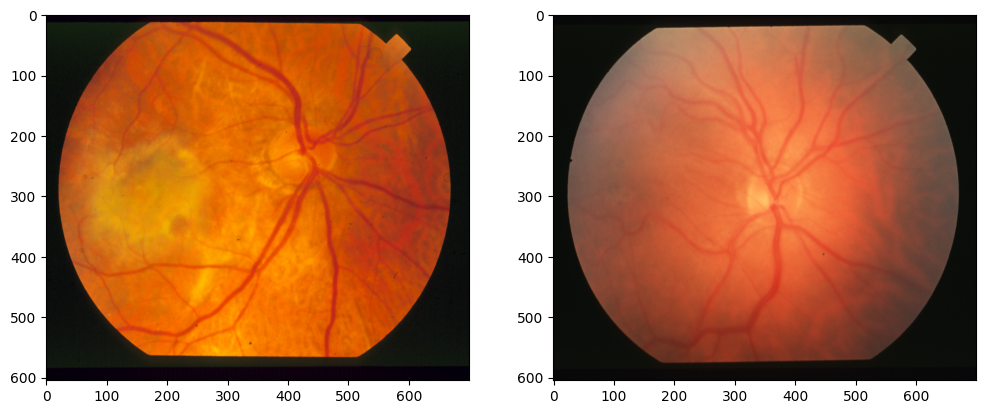

In [39]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

img1=Image.open(df["ImagePath"][0])
ax1.imshow(img1)

img2=Image.open(df["ImagePath"][64])
ax2.imshow(img2)

plt.show()